In [4]:
import numpy as np
import pandas as pd
import re
import string

In [5]:
from google.colab import files
uploaded = files.upload()

Saving Exploration.csv to Exploration.csv


In [7]:
df=pd.read_csv("Exploration.csv")

In [36]:
def clean_text(text):
  if pd.isnull(text):
    return ""
  text=text.lower() #Converts all characters in the text to lowercase
  text=re.sub(r"http\S+","",text) #Removes URLs from the text
  text=re.sub("\d+","",text) #Removes all numbers
  text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
  text = text.strip()                             # Remove leading/trailing whitespace
  return text

In [14]:
df["Pros_clean"]=df["Pros"].apply(clean_text)
df['Cons_clean'] = df['Cons'].apply(clean_text)

Splits each cleaned text into words using .split() and counts how many words are in each.

Helps analyze review length, verbosity, etc.



In [15]:
df["Pros_wordcount"]=df["Pros_clean"].apply(lambda x: len(x.split()))
df['Cons_WordCount'] = df['Cons_clean'].apply(lambda x: len(x.split()))

TextBlob is a simple NLP tool that returns sentiment polarity:

> 0: Positive

< 0: Negative

= 0: Neutral

In [16]:
from textblob import TextBlob
df["Pros_sentiment"]=df["Pros_clean"].apply(lambda x: TextBlob(x).sentiment.polarity)
df['Cons_Sentiment'] = df['Cons_clean'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [31]:
df["Pros_sentiment"]

,Pros_sentiment
0,0.294643
1,0.255729
2,0.152335
3,0.205931
4,0.169186
...,...
67524,0.366667
67525,0.172857
67526,0.650000
67527,0.214286


Example- row has fairly positive value so we will check the text.

In [35]:
df.iloc[67526]["Pros"]

'Nice place to work. Good atmosphere with advancement.'

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=100)  # Keep top 100 important words
pros_tfidf = tfidf.fit_transform(df['Pros_clean'])  # Converts text to numerical TF-IDF format

# Convert to DataFrame and join
pros_tfidf_df = pd.DataFrame(pros_tfidf.toarray(), columns=tfidf.get_feature_names_out())
df = df.join(pros_tfidf_df)


This code converts the cleaned Pros_clean text into numeric features using TF-IDF (Term Frequency-Inverse Document Frequency). It:

Extracts the top 100 important words from all reviews.

Converts each review into a row of TF-IDF scores (how important each word is).

Adds these 100 new columns (one for each word) to your original DataFrame for use in machine learning or analysis.

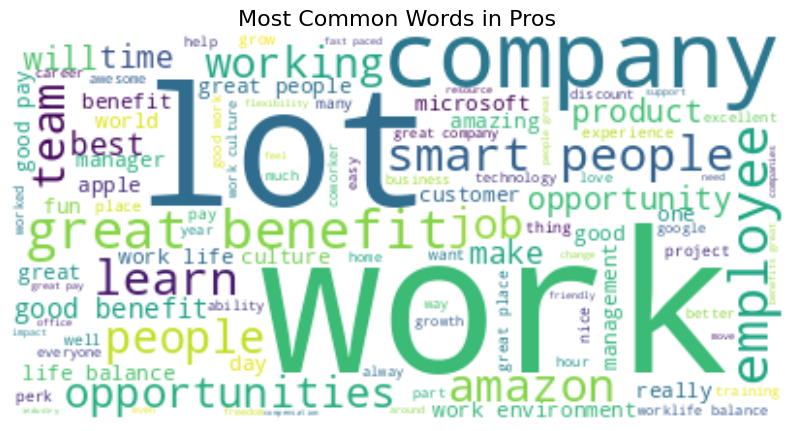

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pros_text = " ".join(df['Pros_clean'].dropna())  # Join all cleaned Pros
wordcloud = WordCloud(background_color='white', max_words=100).generate(pros_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Pros", fontsize=16)
plt.show()


pros_text = " ".join(df['Pros_clean'].dropna()):
Combines all non-null cleaned "Pros" text into one long string.

WordCloud(...):
Creates a word cloud object that will display up to 100 frequent words with a white background.

generate(pros_text):
Builds the word cloud from the combined text.

plt.imshow(...) and plt.show():
Displays the word cloud using Matplotlib, without axis ticks.

In [21]:
!pip install nltk
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

VADER (Valence Aware Dictionary for sEntiment Reasoning) is a pre-trained sentiment analyzer that works well on social media/text reviews and classifies text as:

Positive

Negative

Neutral

```
# This is formatted as code
```



In [22]:
# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment score on 'Pros_clean' and 'Cons_clean'
df['Pros_Sentiment'] = df['Pros_clean'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['Cons_Sentiment'] = df['Cons_clean'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Optional: categorize into sentiment labels
df['Pros_Sentiment_Label'] = df['Pros_Sentiment'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))
df['Cons_Sentiment_Label'] = df['Cons_Sentiment'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))


Loads VADER’s sentiment analyzer to measure sentiment polarity (positive/negative/neutral) from text.
For each row, calculates a compound sentiment score (range: -1 to 1):

Positive → closer to 1

Negative → closer to -1

Neutral → around 0
Converts the numerical sentiment score into a categorical label:

Positive if compound > 0.05

Negative if compound < -0.05

Neutral otherwise



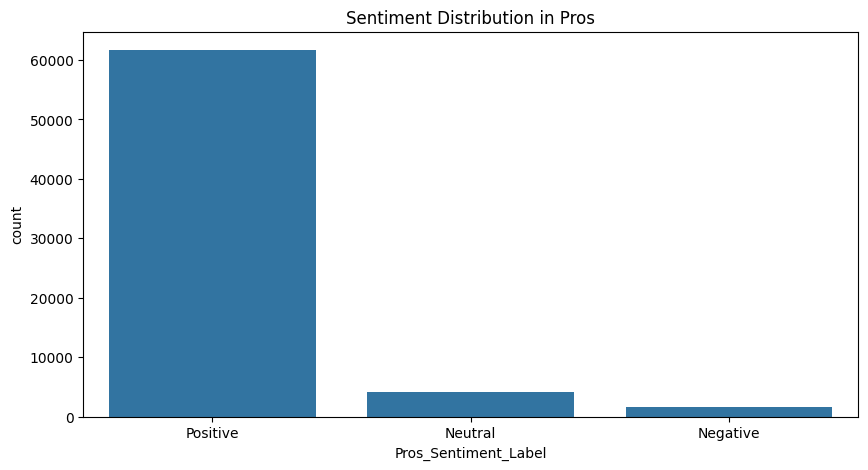

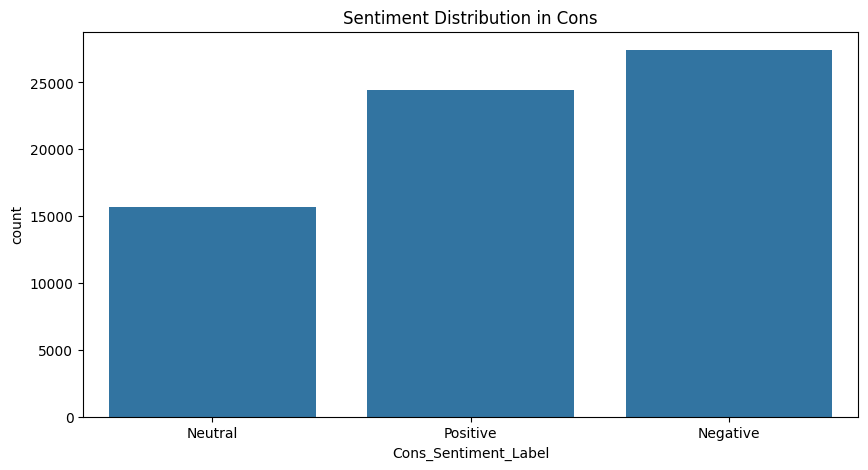

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(x='Pros_Sentiment_Label', data=df)
plt.title('Sentiment Distribution in Pros')
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(x='Cons_Sentiment_Label', data=df)
plt.title('Sentiment Distribution in Cons')
plt.show()


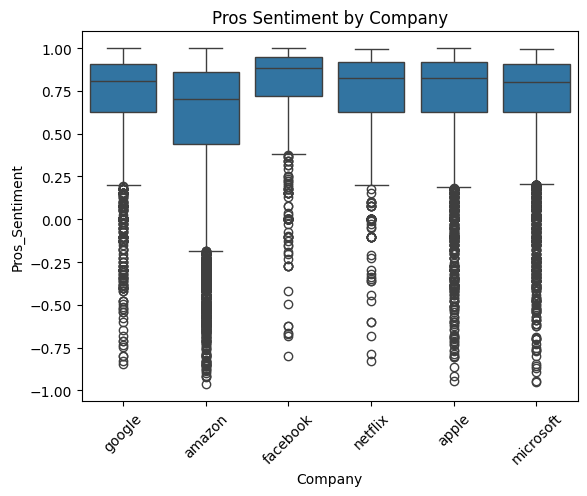

In [24]:
sns.boxplot(x='Company', y='Pros_Sentiment', data=df)
plt.xticks(rotation=45)
plt.title('Pros Sentiment by Company')
plt.show()


This gives a box plot for each company, showing:
Median sentiment,
Interquartile range (IQR)
Potential outliers